# Setup

In [1]:
import multiprocessing as mp

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BertForMaskedLM
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.stem import WordNetLemmatizer

In [2]:
home_path = "/home/semantic/harrando/zeste/"

In [3]:
numberbatch = pickle.load(open(home_path+"numberbatch-en-19.08-en.pickle", 'rb'))

In [4]:
def get_word_neighborhood(word, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if word in numberbatch and ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity(word, ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [5]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [6]:
def get_words_neighborhood(words, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [7]:
mapping = {  'alt.atheism': 'atheism', # 'atheism',
             'comp.graphics': 'graphic',
             'comp.os.ms-windows.misc': 'windows',
             'comp.sys.ibm.pc.hardware': 'hardware',
             'comp.sys.mac.hardware': 'hardware',
             'comp.windows.x': 'windows',
             'misc.forsale': 'sale',
             'rec.autos': 'car',
             'rec.motorcycles': 'motorcycle',
             'rec.sport.baseball': 'baseball',
             'rec.sport.hockey': 'hockey',
             'sci.crypt': 'cryptography',
             'sci.electronics': 'electronics',
             'sci.med': 'medicine',
             'sci.space': 'space',
             'soc.religion.christian': 'christianity',
             'talk.politics.guns': 'gun',
             'talk.politics.mideast': 'middle_east',
             'talk.politics.misc': 'politics',
             'talk.religion.misc': 'religion' }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

18
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']


In [8]:
ls .

 cm_20ng.pdf
'GPU1- Pipeline-Alison-classification-aspects.ipynb'
'GPU3 - Pipeline-Alison-classification.ipynb'
 hg_Zero_Shot_Pipeline.ipynb
 mono_poly_semcor_experiments_data_en.pkl
 neighborhood20k_20ng_hockey_motorcycle.pickle
 neighborhood20k_20ng_hockey_no_prompt.pickle
 neighborhood20k_20ng_is_about_definition_yahoo.pickle
 neighborhood20k_20ng_is_about_domain_deberta.pickle
 neighborhood20k_20ng_is_about_domain.pickle
 neighborhood20k_20ng_is_about_domain_XLM-RoBERTa-large-XNLI-ANLI.pickle
 neighborhood20k_20ng_is_about_domain_yahoo.pickle
 neighborhood20k_20ng.pickle
 neighborhood20k_csi_default_classifier.pickle
 polysemy_bands_semcor_experiments_data.pkl
 ProZe-GPT-Alison.ipynb
'ProZe - Pipeline-Alison-classification.ipynb'
'ProZe - Pipeline-Alison.ipynb'
'ProZe - Pipeline-Hop1-Filtering.ipynb'
'ProZe - Pipeline.ipynb'
 ProZe-thomas.ipynb
 Untitled.ipynb


In [9]:
os.path.exists(home_path+'labels_cgr_20ng.pickle')

True

In [10]:
%%time

if os.path.exists(home_path+'labels_cgr_20ng.pickle'):
    labels_cgr = pickle.load(open(home_path+'labels_cgr_20ng.pickle', 'rb'))

else:
    pbar = tqdm(labels)
    labels_cgr = {}
    for label in pbar:
        pbar.set_description(label)
        labels_cgr[label] = get_words_neighborhood(label, 3, 'all', keep='top20000')

CPU times: user 3.01 s, sys: 222 ms, total: 3.23 s
Wall time: 3.23 s


In [11]:
labels_cgr['atheism'].keys()

dict_keys(['atheism', 'panentheism', 'atheistic', 'antiatheistic', 'atheistically', 'deism', 'atheologist', 'panatheism', 'apeirotheism', 'religion', 'atheistical', 'atheisms', 'antiatheist', 'tritheism', 'atheophobia', 'monotheism', 'atheist', 'learning_about_science', 'unbelief', 'agnosticism', 'omnitheism', 'theism', 'adevism', 'atheisticalness', 'deconversion', 'new_atheism', 'ultra_darwinism', 'atheology', 'tetratheism', 'polytheism', "pascal's_wager", 'pantheism', 'belief', 'god', 'secularism', 'atheophobic', 'monolatrism', 'apatheism', 'atheophobe', 'antimetaphysics', 'personal_god', 'impersonal', 'deity', 'anthropomorphized', 'physicalism', 'delusion', 'philosophy', 'metaphysics', 'antimetaphysically', 'antimetaphysical', 'anti_metaphysics', 'ametaphysics', 'positivism', 'materialism', 'antimetaphysicality', 'theophobe', 'religiophobe', 'apathy', 'apatheist', 'apathetic', 'agnostic', 'ignosticism', 'monolatry', 'monolatrous', 'ditheism', 'kathenotheism', 'henotheism', 'monolate

In [12]:
labels_cgr['atheism']['panentheism']['sim']

0.644391

In [13]:
options = {
    'model_name':  'EleutherAI/gpt-j-6B',#'bert-large-uncased-whole-word-masking',#'bert-base-uncased',#'EleutherAI/gpt-neo-2.7B',#'xlnet-base-cased',#'roberta-large',
    'prompt': {},
}

In [14]:
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']

['atheism',
 'baseball',
 'car',
 'christianity',
 'cryptography',
 'electronics',
 'graphic',
 'gun',
 'hardware',
 'hockey',
 'medicine',
 'middle_east',
 'motorcycle',
 'politics',
 'religion',
 'sale',
 'space',
 'windows']

In [15]:
#options['prompt']['atheism'] = 'Atheism is an absence of belief in the existence of God.'
#options['prompt']['baseball'] = 'Baseball is a bat-and-ball game played between two opposing teams, typically of nine players each, that take turns batting and fielding.'
#options['prompt']['car'] = 'A car or automobile is a wheeled motor vehicle used for transportation. Most definitions of cars say that they run primarily on roads, seat one-to-eight people, have four wheels and mainly transport people rather than goods.'
#options['prompt']['christianity'] = 'Christianity is an Abrahamic, monotheistic religion based on the life and teachings of Jesus of Nazareth. It is the world\'s largest religion.'
#options['prompt']['cryptography'] = 'Cryptography or cryptology is the practice and study of techniques for secure communication in the presence of adversarial behavior.'
#options['prompt']['electronics'] = 'Electronics comprises the physics, engineering, technology and applications that deal with the emission, flow and control of electrons in vacuum and matter.'
#options['prompt']['graphic'] = 'Graphics are visual images or designs on some surface, such as a wall, canvas, screen, paper, or stone to inform, illustrate, or entertain. It includes a pictorial representation of data, as in design and manufacture, in typesetting and the graphic arts, and in educational and recreational software.'
#options['prompt']['gun'] = 'A gun is a ranged weapon designed to use a shooting tube (gun barrel) to launch typically solid projectiles'
#options['prompt']['hardware'] = 'Computer hardware includes the physical parts of a computer, such as the case, central processing unit (CPU), monitor, mouse, keyboard, computer data storage, graphics card, sound card, speakers and motherboard.'
#options['prompt']['hockey'] = 'Hockey is a sport in which two teams play against each other by trying to manoeuvre a ball or a puck into the opponent\'s goal using a hockey stick'
#options['prompt']['medicine'] = 'Medicine is the science and practice of caring for a patient, managing the diagnosis, prognosis, prevention, treatment, palliation of their injury or disease, and promoting their health.'
#options['prompt']['middle_east'] = 'The Middle East is a geopolitical term that commonly refers to the region spanning the Levant, Arabian Peninsula, Anatolia (including modern Turkey and Cyprus), Egypt, Iran and Iraq.'
#options['prompt']['motorcycle'] = 'A motorcycle, often called a motorbike, bike, or cycle, is a two- or three-wheeled motor vehicle.'
#options['prompt']['politics'] = 'Politics is the set of activities that are associated with making decisions in groups, or other forms of power relations between individuals, such as the distribution of resources or status.'
#options['prompt']['religion'] = 'Religion is a social-cultural system of designated behaviors and practices, morals, beliefs, worldviews, texts, sanctified places, prophecies, ethics, or organizations, that relates humanity to supernatural, transcendental, and spiritual elements.'
#options['prompt']['sale'] = 'Sales are activities related to selling or the number of goods sold in a given targeted time period. The delivery of a service for a cost is also considered a sale.'
#options['prompt']['space'] = 'Outer space is the expanse that exists beyond Earth and between celestial bodies.'
#options['prompt']['windows'] = 'Windows is a group of several proprietary graphical operating system families, all of which are developed and marketed by Microsoft. Each family caters to a certain sector of the computing industry.'

options['prompt']['atheism'] = 'atheism'
options['prompt']['baseball'] = 'sport'
options['prompt']['car'] = 'autos'
options['prompt']['christianity']='religion'
options['prompt']['cryptography'] = 'science'
options['prompt']['electronics'] = 'science'
options['prompt']['graphic'] = 'computer'
options['prompt']['gun'] ='politics'
options['prompt']['hockey'] ='sport'
options['prompt']['hardware'] = 'computer'
options['prompt']['medicine']='science'
options['prompt']['middle_east'] = 'politics'
options['prompt']['motorcycle'] = 'motorcycles'
options['prompt']['politics'] = 'politics'
options['prompt']['religion'] = 'religion'
options['prompt']['sale'] = 'sale'
options['prompt']['space'] = 'science'#'universe'
options['prompt']['windows'] = 'computer'

## Filter with the LM

In [16]:
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

#device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(options['model_name'])
bert = BertForMaskedLM.from_pretrained('bert-large-uncased-whole-word-masking')
config = AutoConfig.from_pretrained(options['model_name'])
model = AutoModelForCausalLM.from_pretrained(options['model_name'])

#tokenizer = RemBertTokenizer.from_pretrained('google/rembert')
#config = RemBertConfig.from_pretrained("google/rembert")
#model = RemBertModel.from_pretrained("google/rembert", config=config)

print("GPTJConfig, RemBertConfig, RoFormerConfig, BigBirdPegasusConfig, GPTNeoConfig, BigBirdConfig, Speech2Text2Config, BlenderbotSmallConfig, BertGenerationConfig, CamembertConfig, XLMRobertaConfig, PegasusConfig, MarianConfig, MBartConfig, MegatronBertConfig, BartConfig, BlenderbotConfig, ReformerConfig, RobertaConfig, BertConfig, OpenAIGPTConfig, GPT2Config, TransfoXLConfig, XLNetConfig, XLMProphetNetConfig, ProphetNetConfig, XLMConfig, CTRLConfig."\
    )

__CUDNN VERSION: 8005
__Number CUDA Devices: 4
__Devices
Active CUDA Device: GPU 0
Available devices  4
Current cuda device  0


KeyError: 'gptj'

In [234]:



## bert_vocab = tokenizer.get_vocab()
#reverse_vocab = {i:w for w,i in bert_vocab.items()}
#len(bert_vocab)

model_vocab = tokenizer.get_vocab()
reverse_vocab = {i:w for w,i in model_vocab.items()}
len(model_vocab)

50400

In [235]:
labels_mapping = {'atheism':'Atheism', 
                  'baseball':'Baseball', 
                  'car': 'A car', 
                  'christianity': 'Christianity', 
                  'cryptography': 'Cryptography', 
                  'electronics': 'Electronics', 
                  'graphic': 'Graphics', 
                  
                  'gun': 'A gun', 
                  'hardware': 'Hardware', 
                  'hockey': 'Hockey', 
                  'medicine': 'Medicine', 
                  'middle_east': 'The Middle East', 
                  'motorcycle': 'A motorcycle', 
                  'politics': 'Politics', 
                  'religion': 'Religion', 
                  'sale': 'A sale', 
                  'space': 'Space', 
                  'windows': 'Windows'
}

In [236]:
tokenizer.mask_token

Using mask_token, but it is not set yet.


In [237]:
#template

In [238]:
#tokens_idx

In [277]:
%time
candidates_scores = {}

# options['prompt'] = 'an opening in the wall or roof of a building or vehicle that is fitted with glass or other transparent material in a frame to admit light or air and allow people to see out.'

for label in options['prompt']:
    #template = f"{options['prompt'][label]} [SEP] {labels_mapping[label]} is related to {tokenizer.mask_token}."
    template = f"The definition of {options['prompt'][label]} is as follows: "
    input_ids = tokenizer(template, return_tensors="pt").input_ids
    gen_tokens = model.generate(input_ids, do_sample=True, temperature=0.4, max_length=30,)
    gen_text = tokenizer.batch_decode(gen_tokens)[0]
    #filtered = list(set(nltk.word_tokenize(gen_text.lower())) - set(nltk.corpus.stopwords.words('english')))
    last_word = gen_text.split()[-1]
    lemmatizer = WordNetLemmatizer()
    lemma = ''.join([lemmatizer.lemmatize(last_word.lower())])
    #lemmas = lemmas.replace("related",'')
    #words = lemmas.split()
    #words = " ".join(sorted(set(words), key=words.index))
    #final = ''.join([i for i in words if i not in string.punctuation])
    print("Generated Text: ",gen_text)
    print("Final output: ",lemma)


    tokens_idx = tokenizer.encode(lemma)
    

    #print(tokens_idx)
    # print(template, len(template))
    tokens = tokenizer.convert_ids_to_tokens(tokens_idx)
    print(tokens_idx)
    # print(tokens, len(tokens))

    scores = model(torch.tensor([tokens_idx]))[0][0][0].detach().numpy()
    
    candidates_scores[label] = sorted([(reverse_vocab[i], s) for i,s in enumerate(scores)], key=lambda c: -c[1])

    # print(logits.shape)
    print(label, '   ', candidates_scores[label][:20])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 28.4 µs
Generated Text:  The definition of atheism is as follows: 

The absence of belief in a god or gods.

This is a very broad definition,
Final output:  definition,
[46758, 11]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


atheism     [('.', 13.171864), ('Ġof', 13.085235), (',', 12.334017), ('/', 12.207305), ('_', 11.814041), ('-', 11.794844), (':', 11.740257), ('Ċ', 11.528677), ('\\', 11.185453), (')', 11.113272), ('(', 11.095841), (';', 10.804715), ('Ġ(', 10.788214), ('"', 10.7648115), ('Ġand', 10.680129), ('Ġ', 10.156632), ('Ġfor', 10.143082), ('Ġ=', 10.114841), ('Ġis', 10.100383), (']', 10.067071)]
Generated Text:  The definition of sport is as follows: 

Sport is an activity involving physical exertion and skill where participants compete against each other.


Final output:  other.
[847, 13]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


baseball     [('wise', 11.803185), ('s', 11.515826), ('mic', 11.43148), ('ape', 11.418818), (',', 10.7601795), ('.', 10.715855), ('_', 10.368891), ('Ġthan', 10.327739), (')', 10.085781), ('ap', 10.061162), ('ing', 10.061084), ('mia', 10.053048), ('Ċ', 9.878259), ('apist', 9.856288), ('m', 9.817431), (':', 9.648177), ('Ġpeople', 9.578626), ('"', 9.569143), ('-', 9.41742), ('\\', 9.387273)]
Generated Text:  The definition of autos is as follows: 

The word autos is an abbreviation of auto-da-fé, a term for the
Final output:  the
[1169]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


car     [('ta', 10.633024), ('-', 9.826301), ('Ġsecond', 9.01622), ('Ċ', 9.005242), ('Ġthird', 8.926937), ('Ġnearest', 8.918417), ('Ġmost', 8.669281), ('Ġ"', 8.609659), ('Ġfirst', 8.580574), ('Âł', 8.348311), ('Ġremainder', 8.345944), ('Ġprime', 8.226519), ('Ġbest', 8.210694), ('Ġsame', 8.138393), ('Ġmain', 7.963936), ('ory', 7.9508486), ('Ġworld', 7.9291577), ('Ġother', 7.9129534), ('_', 7.907384), ('Ġtwo', 7.896959)]
Generated Text:  The definition of religion is as follows: 

Religion is a system of beliefs and practices that encompasses a
  wide range of phenomena,
Final output:  phenomena,
[31024, 3674, 64, 11]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


christianity     [('yl', 17.29251), ('ol', 16.184675), ('ols', 15.20484), ('y', 15.114064), ('omen', 14.460871), ('otype', 14.305202), ('olic', 14.055556), ('ox', 13.819221), ('otypes', 13.595855), ('yle', 13.590409), ('ylene', 13.527588), ('ome', 13.189967), ('otyp', 13.168898), ('oxy', 12.993906), ('oid', 12.966426), ('one', 12.813872), ('oth', 12.728135), ('oma', 12.664154), ('us', 12.570204), (',', 12.43071)]
Generated Text:  The definition of science is as follows: 

Science is the organized, systematic, and objective pursuit of knowledge.

The definitions of the
Final output:  the
[1169]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


cryptography     [('ta', 10.633024), ('-', 9.826301), ('Ġsecond', 9.01622), ('Ċ', 9.005242), ('Ġthird', 8.926937), ('Ġnearest', 8.918417), ('Ġmost', 8.669281), ('Ġ"', 8.609659), ('Ġfirst', 8.580574), ('Âł', 8.348311), ('Ġremainder', 8.345944), ('Ġprime', 8.226519), ('Ġbest', 8.210694), ('Ġsame', 8.138393), ('Ġmain', 7.963936), ('ory', 7.9508486), ('Ġworld', 7.9291577), ('Ġother', 7.9129534), ('_', 7.907384), ('Ġtwo', 7.896959)]
Generated Text:  The definition of science is as follows: 

Science is the process of acquiring knowledge or information through observation, experimentation, measurement, or calculation.
Final output:  calculation.
[9948, 14902, 13]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


electronics     [('{', 16.52245), ('ĠH', 13.824772), ('ĠF', 13.803519), ('ĠM', 13.787229), ('ĠL', 13.609954), ('ĠA', 13.544303), ('ĠC', 13.475584), ('ĠD', 13.439959), ('ĠB', 13.268414), ('ĠQ', 13.265999), ('endar', 13.250428), ('ĠR', 13.247463), ('ĠS', 13.24444), ('ĠE', 13.212299), ('ĠG', 13.073904), ('ĠO', 12.97274), ('ĠP', 12.773368), ('ĠV', 12.748319), ('ĠK', 12.663901), ('ĠT', 12.575294)]
Generated Text:  The definition of computer is as follows: 

A computer is a machine that uses a digital computing system to
  process data.


Final output:  data.
[7890, 13]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


graphic     [('-', 14.635554), ('.', 13.963205), (',', 13.703348), ('_', 13.527418), ('Ġ=', 13.115274), (');', 13.024726), (')', 13.019937), ('/', 12.797657), (';', 12.757961), (':', 12.733478), ('[', 12.396125), ('(', 12.381159), ('Ċ', 12.322901), ('>', 12.196847), ('->', 12.129203), ('></', 11.627045), ("['", 11.5894165), ('Ġ*', 11.369191), ('\\', 11.297178), ('Type', 11.23379)]
Generated Text:  The definition of politics is as follows: 

Politics is the art of getting people to do what you want them to do.

The
Final output:  the
[1169]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


gun     [('ta', 10.633024), ('-', 9.826301), ('Ġsecond', 9.01622), ('Ċ', 9.005242), ('Ġthird', 8.926937), ('Ġnearest', 8.918417), ('Ġmost', 8.669281), ('Ġ"', 8.609659), ('Ġfirst', 8.580574), ('Âł', 8.348311), ('Ġremainder', 8.345944), ('Ġprime', 8.226519), ('Ġbest', 8.210694), ('Ġsame', 8.138393), ('Ġmain', 7.963936), ('ory', 7.9508486), ('Ġworld', 7.9291577), ('Ġother', 7.9129534), ('_', 7.907384), ('Ġtwo', 7.896959)]
Generated Text:  The definition of computer is as follows: 

A computer is a programmable machine that can be programmed to
  perform a specific task.
Final output:  task.
[35943, 13]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


hardware     [('_', 13.453938), ('.', 13.400342), ('-', 13.009125), (',', 12.428246), (')', 12.141076), ('>', 11.79284), ('Ċ', 11.75766), ('">', 11.672697), ('(', 11.472238), ('/', 11.44097), (':', 11.365934), (';', 11.321901), (');', 11.283847), ('Ġ=', 11.1465), ('->', 11.036089), ('1', 10.884611), ('":', 10.810221), ('2', 10.785634), ('\\', 10.64053), ('Ġis', 10.617629)]
Generated Text:  The definition of sport is as follows:                “Sport is an activity,
Final output:  activity,
[21797, 11]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


hockey     [('.', 13.343286), (',', 12.852979), ('Ġin', 12.583307), ('Ġof', 12.518355), ('Ċ', 12.437579), ('_', 12.396072), ('-', 12.206797), ('Ġ(', 12.142197), ('Ġis', 11.777403), ('Ġand', 11.768083), ('Ġwas', 11.554692), ('Ġto', 11.393413), ('Ġ{', 11.373804), ('/', 11.2893505), (':', 11.133079), (';', 11.061691), ('Ġ', 11.0238085), (')', 10.941394), ('Ġwith', 10.935153), ('Ġat', 10.696134)]
Generated Text:  The definition of science is as follows: 

Science is a systematic enterprise that builds and organizes knowledge in the form of testable explanations and
Final output:  and
[392]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


medicine     [('-', 10.98142), ('Ġthe', 10.839112), (',', 10.079868), ('Ġmany', 9.37739), ('Ġa', 9.34026), ('Ċ', 9.292218), ('Ġthen', 9.167196), ('_', 9.158283), ('Ġthat', 9.029005), ('Ġit', 8.965456), ('Ġin', 8.732323), ('Ġ(', 8.731834), ('Ġis', 8.640051), ('Ġfor', 8.565843), ('Ġto', 8.563699), ('Ġall', 8.524307), ('Ġ$', 8.517115), ('ĠI', 8.478839), ('.', 8.476066), ('Ġsome', 8.386957)]
Generated Text:  The definition of politics is as follows:                Politics is the art of getting

Final output:  getting
[37210]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


middle_east     [('Ġthe', 11.844652), ('Ġa', 11.634873), ('Ġto', 10.957021), ('_', 10.729761), ('Ġout', 10.386971), ('Ġall', 10.33744), ('Ġup', 10.198728), ('Ġan', 10.161196), ('Ġsome', 10.017412), ('-', 9.990888), ('Ġyour', 9.832753), (',', 9.821641), ('Ġback', 9.78257), ('Ġmy', 9.705786), ('Ġin', 9.699075), ('Ġinto', 9.681233), ('Ġthem', 9.616352), ('Ġit', 9.606646), (':', 9.4990635), ('Ġaway', 9.40952)]
Generated Text:  The definition of motorcycles is as follows: 

A motorcycle is a two-wheeled vehicle that is propelled by an engine with a shaft that
Final output:  that
[5562]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


motorcycle     [('Ġthe', 12.098652), ('Ġis', 11.392267), ("'s", 10.946702), (',', 10.756585), ('Ġit', 10.495652), ('Ġwas', 10.259316), ('Ġhe', 10.230884), ('Ġa', 9.949392), ('Ġwe', 9.8545475), ('.', 9.812657), ('Ġshe', 9.812448), ('Ġyou', 9.811019), ('Ġthis', 9.809672), ('Ċ', 9.647291), ('Ġare', 9.638374), ('âĢ', 9.6291), ('ĠI', 9.621936), ('Ġthere', 9.618248), ('Ġwould', 9.6065645), ('Âł', 9.558094)]
Generated Text:  The definition of politics is as follows: 

Politics is a social science that studies the process of
  government.

However, the
Final output:  the
[1169]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


politics     [('ta', 10.633024), ('-', 9.826301), ('Ġsecond', 9.01622), ('Ċ', 9.005242), ('Ġthird', 8.926937), ('Ġnearest', 8.918417), ('Ġmost', 8.669281), ('Ġ"', 8.609659), ('Ġfirst', 8.580574), ('Âł', 8.348311), ('Ġremainder', 8.345944), ('Ġprime', 8.226519), ('Ġbest', 8.210694), ('Ġsame', 8.138393), ('Ġmain', 7.963936), ('ory', 7.9508486), ('Ġworld', 7.9291577), ('Ġother', 7.9129534), ('_', 7.907384), ('Ġtwo', 7.896959)]
Generated Text:  The definition of religion is as follows: 
A set of beliefs and practices that are held to be sacred, and that are transmitted from one generation
Final output:  generation
[20158]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


religion     [('Ġof', 10.900489), (',', 10.848956), ('.', 10.181731), ('Ġmicro', 9.791809), ('Ġ(', 9.708457), ('Ġand', 9.702542), ('-', 9.680234), ('Ġtechnology', 9.4290085), ('Ġin', 9.382884), ('Ġmethod', 9.355174), ('Ġmethods', 9.289154), (':', 9.272889), ('_', 9.128902), ('Ċ', 9.050331), ('Ġtherapy', 9.007711), ('Ġtechnologies', 8.997738), ('Ġdrug', 8.91206), ('Ġdigital', 8.899438), ('Ġsystems', 8.888296), ('Ġis', 8.814025)]
Generated Text:  The definition of sale is as follows:  "A sale is an agreement whereby the seller transfers the property in question to the buyer for a price in
Final output:  in
[259]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


sale     [('Ġ\\', 11.423574), ('-', 11.118585), (',', 10.972367), ('fty', 10.94749), ('Ġthe', 10.648517), ('\\', 10.543489), ('.', 10.290696), ('Ġ(', 10.196809), ('Ċ', 10.154374), ('Ġ{\\', 9.774117), ('}{', 9.376374), ("'", 9.36806), ('Ġand', 9.3578615), ('Ġa', 9.263039), ('Ġvitro', 9.220745), ('ĠB', 9.194153), ('Ġvivo', 9.171546), ('_', 9.078917), ('ĠL', 9.07387), ('ĠH', 9.06133)]
Generated Text:  The definition of science is as follows: 

Science is the organized, systematic, and critical study of the
  phenomena of the physical and
Final output:  and
[392]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


space     [('-', 10.98142), ('Ġthe', 10.839112), (',', 10.079868), ('Ġmany', 9.37739), ('Ġa', 9.34026), ('Ċ', 9.292218), ('Ġthen', 9.167196), ('_', 9.158283), ('Ġthat', 9.029005), ('Ġit', 8.965456), ('Ġin', 8.732323), ('Ġ(', 8.731834), ('Ġis', 8.640051), ('Ġfor', 8.565843), ('Ġto', 8.563699), ('Ġall', 8.524307), ('Ġ$', 8.517115), ('ĠI', 8.478839), ('.', 8.476066), ('Ġsome', 8.386957)]
Generated Text:  The definition of computer is as follows: 

A computer is a machine that can be programmed to perform a specific task or a group of tasks
Final output:  task
[35943]
windows     [('_', 13.453934), ('.', 13.400339), ('-', 13.00912), (',', 12.42824), (')', 12.141073), ('>', 11.792843), ('Ċ', 11.757656), ('">', 11.6727), ('(', 11.472229), ('/', 11.440964), (':', 11.365928), (';', 11.321897), (');', 11.283844), ('Ġ=', 11.146496), ('->', 11.036089), ('1', 10.88461), ('":', 10.810219), ('2', 10.785631), ('\\', 10.640528), ('Ġis', 10.617623)]


In [242]:
labels_cgr.keys()

dict_keys(['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows'])

In [243]:
neighborhood = {}
for label in tqdm(labels_cgr):
    neighborhood[label] = {}
    dd = dict(candidates_scores[label][:20000])
    for word in labels_cgr[label]:
        if word in dd:
            neighborhood[label][word] = (labels_cgr[label][word]['sim'], dd[word])

  0%|          | 0/18 [00:00<?, ?it/s]

In [244]:
for label in neighborhood:
    total = max([x[1] for x in neighborhood[label].values()])
    for word in neighborhood[label]:
        neighborhood[label][word] = (neighborhood[label][word][0], neighborhood[label][word][1]/total)

In [245]:
sorted([(k, d['sim']) for k, d in labels_cgr['baseball'].items()], key=lambda x: -x[1])

[('baseball', 1.0),
 ('charging_mound', 0.9978942),
 ('baseballing', 0.9978942),
 ('ghost_runner', 0.9840192),
 ('batting_coach', 0.9769366),
 ('pitching_coach', 0.9769366),
 ('hit_ball_squarely', 0.973795),
 ('three_hitter', 0.9703248),
 ('one_hitter', 0.9699128),
 ('four_hitter', 0.9696816),
 ('five_hitter', 0.96914554),
 ('push_bunt', 0.95842916),
 ('two_hitter', 0.9554656),
 ('dead_red', 0.9502086),
 ('setup_man', 0.94866115),
 ('push_bunts', 0.9470002),
 ('no_hit_game', 0.94420666),
 ('can_of_corn', 0.9398043),
 ('circuit_slugger', 0.9397104),
 ('ptbnl', 0.9387398),
 ('strike_out_looking', 0.9378957),
 ('hidden_ball_trick', 0.9359189),
 ('baseball_coach', 0.93579566),
 ('pitcher_mound', 0.9351494),
 ('warning_track', 0.93427753),
 ('perfect_game', 0.9333116),
 ('league_championship_series', 0.93128854),
 ('up_to_bat', 0.9298937),
 ('played_on', 0.92968506),
 ('dying_quail', 0.92889315),
 ('baseballese', 0.923704),
 ('seeing_eye_ball', 0.92314374),
 ('rough_up_bullpen', 0.92079604)

In [246]:
sorted(neighborhood['atheism'].items(), key=lambda x: -x[1][0])

[('istical', (0.62493086, 0.1572508)),
 ('religious', (0.4145326, 0.17210534)),
 ('icism', (0.40463996, 0.36273926)),
 ('istically', (0.4031701, 0.19920732)),
 ('god', (0.37906212, 0.40396133)),
 ('uu', (0.34955025, 0.30330524)),
 ('ider', (0.33754763, 0.49706444)),
 ('deen', (0.3042351, 0.2700107)),
 ('perate', (0.3011971, 0.38584328)),
 ('awan', (0.2945299, 0.38407123)),
 ('church', (0.27030054, 0.10430839)),
 ('iman', (0.25891012, 0.23579928)),
 ('rational', (0.25862765, 0.43250644)),
 ('christ', (0.25784123, 0.17662226)),
 ('allah', (0.25416046, 0.2632936)),
 ('arian', (0.24682379, 0.47753674)),
 ('aten', (0.24407141, 0.39367443)),
 ('sect', (0.2361066, 0.35155848)),
 ('asha', (0.22020769, 0.4034268)),
 ('athan', (0.21629581, 0.2547198)),
 ('rak', (0.20306776, 0.63295543)),
 ('arius', (0.1931514, 0.36784214)),
 ('jah', (0.18750642, 0.45258066)),
 ('arg', (0.1815518, 0.48339897)),
 ('ism', (0.17811942, 0.64120084)),
 ('assert', (0.1771466, 0.28445286)),
 ('akh', (0.17587948, 0.45110

In [247]:
sorted(neighborhood['atheism'].items(), key=lambda x: -x[1][1])

[('ac', (0.08692925, 1.0)),
 ('ra', (0.08660793, 0.8130334)),
 ('om', (0.084847376, 0.80078256)),
 ('id', (0.10322306, 0.79555285)),
 ('is', (0.10231581, 0.79223716)),
 ('az', (0.08341523, 0.7522269)),
 ('ler', (0.09665011, 0.7476728)),
 ('ist', (0.111621246, 0.7224148)),
 ('ada', (0.08418388, 0.72183526)),
 ('vel', (0.114992395, 0.6964867)),
 ('zen', (0.16346839, 0.66971755)),
 ('aa', (0.09053482, 0.6570824)),
 ('ism', (0.17811942, 0.64120084)),
 ('rak', (0.20306776, 0.63295543)),
 ('adi', (0.12282721, 0.62194747)),
 ('rev', (0.10463047, 0.6146095)),
 ('ind', (0.090936214, 0.614173)),
 ('arch', (0.13588625, 0.6110075)),
 ('ira', (0.15677351, 0.60335624)),
 ('ary', (0.09079717, 0.59810174)),
 ('ala', (0.098033056, 0.56758404)),
 ('rs', (0.0827264, 0.550733)),
 ('rant', (0.10930708, 0.5316307)),
 ('sky', (0.093358785, 0.52545875)),
 ('atum', (0.11419555, 0.52241224)),
 ('ger', (0.086322114, 0.520188)),
 ('ades', (0.121793956, 0.5172548)),
 ('amp', (0.08223608, 0.51410574)),
 ('aris', (0

In [248]:
sorted(neighborhood['christianity'].items(), key=lambda x: -x[1][1])

[('ens', (0.123775065, 1.0)),
 ('icon', (0.16634142, 0.773034)),
 ('emo', (0.11993083, 0.7671207)),
 ('ame', (0.12812567, 0.75515383)),
 ('icism', (0.30745396, 0.718699)),
 ('ce', (0.12130456, 0.67550606)),
 ('ethe', (0.12588067, 0.6549527)),
 ('ark', (0.15438011, 0.63763547)),
 ('st', (0.18012518, 0.62646437)),
 ('unction', (0.21731171, 0.593589)),
 ('jah', (0.23827672, 0.5857231)),
 ('arius', (0.22062954, 0.5815098)),
 ('zen', (0.20868568, 0.5812032)),
 ('jon', (0.1614328, 0.58021873)),
 ('rev', (0.20996685, 0.5681864)),
 ('eve', (0.19076096, 0.5666414)),
 ('unity', (0.2117316, 0.5596111)),
 ('mission', (0.122533254, 0.5562861)),
 ('awan', (0.23920715, 0.5476737)),
 ('sin', (0.20219031, 0.5429841)),
 ('angle', (0.15818949, 0.5429351)),
 ('isha', (0.19632895, 0.5336153)),
 ('bach', (0.1270093, 0.525454)),
 ('amina', (0.12246377, 0.52349305)),
 ('enos', (0.23927136, 0.5226315)),
 ('lection', (0.13333711, 0.50857663)),
 ('iden', (0.12317031, 0.50194234)),
 ('god', (0.42232424, 0.5017972

In [249]:
for label in neighborhood:
    print(label, ':', len(neighborhood[label]))

atheism : 162
baseball : 223
car : 93
christianity : 148
cryptography : 100
electronics : 145
graphic : 112
gun : 74
hardware : 68
hockey : 132
medicine : 18
middle_east : 51
motorcycle : 238
politics : 56
religion : 42
sale : 118
space : 95
windows : 386


# Evaluation

In [250]:
ds_20ng = pd.read_csv(home_path+'datasets/20ng_preprocessed_dataset.csv')
ds_20ng.head()

Unnamed: 0                  label  \
0           0              rec.autos   
1           1  comp.sys.mac.hardware   
2           2  comp.sys.mac.hardware   
3           3          comp.graphics   
4           4              sci.space   

                                                text  
0  car wondering anyone could enlighten car saw d...  
1  clock poll final call summary final call clock...  
2  question well folk mac plus finally gave ghost...  
3  weitek robert kyanko wrote writes far low leve...  
4  shuttle launch question error wondering expect...

In [251]:
for x in ds_20ng[ds_20ng.label == 'soc.religion.christian'].text.head(5):
    print(x)

pantheism environmentalism doe anybody see current emphasis environment turned unintentionally course pantheism yes adamantly environmentalist styrofoam table service please keep mind read post wish attack environmentalism half truth least dangerous complete lie complete lie rarely readily accepted half truth lie subtly hidden powerfully offered masquerade angel light satan people loosened grip treating earth something god intricate handiwork something health future generation based treated respect think going happily leave error rejected style push people opposite error therefore earth god intricate handiwork rubbish god mother earth primarily love serve see two facet response care environment treat proper respect god intricate handiwork health future generation showing facet disregardful thing doe constitute apostle paul called becoming thing men possible mean might save say forget environment got important thing spend time putting foot mouth manner destroy credibility expressing thi

In [252]:
mapping = {  'alt.atheism': 'atheism', # 'atheism',
             'comp.graphics': 'graphic',
             'comp.os.ms-windows.misc': 'windows',
             'comp.sys.ibm.pc.hardware': 'hardware',
             'comp.sys.mac.hardware': 'hardware',
             'comp.windows.x': 'windows',
             'misc.forsale': 'sale',
             'rec.autos': 'car',
             'rec.motorcycles': 'motorcycle',
             'rec.sport.baseball': 'baseball',
             'rec.sport.hockey': 'hockey',
             'sci.crypt': 'cryptography',
             'sci.electronics': 'electronics',
             'sci.med': 'medicine',
             'sci.space': 'space',
             'soc.religion.christian': 'christianity',
             'talk.politics.guns': 'gun',
             'talk.politics.mideast': 'middle_east',
             'talk.politics.misc': 'politics',
             'talk.religion.misc': 'religion' }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

18
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']


In [253]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            if 'sim' in label_neighborhood[token]:
                similarity = label_neighborhood[token]['sim']
            else:
                similarity = label_neighborhood[token][0] * label_neighborhood[token][1] 
            if similarity > 0:
                # related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [254]:
def scoring_document(doc, labels=labels_cgr):
    return np.argmax([get_document_score(doc, labels[l]) for l in labels])

def generate_predictions(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document, corpus_preprocessed)
    return predictions

def scoring_document_pro(doc, labels=neighborhood):
    return np.argmax([get_document_score(doc, labels[l]) for l in labels])

def generate_predictions_pro(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document_pro, corpus_preprocessed)
    return predictions

In [255]:
print("Number of processors: ", mp.cpu_count() - 1)

Number of processors:  31


In [256]:
%%time
pool = mp.Pool(mp.cpu_count() - 1)
data_20ng = pool.map(preprocess, ds_20ng.text)
pool.close()

CPU times: user 763 ms, sys: 29.9 s, total: 30.7 s
Wall time: 28.4 s


In [257]:
get_document_score(data_20ng[0], neighborhood['car'])

1.794168148189783

In [258]:
%%time
predictions = generate_predictions(data_20ng)
print(len(predictions))
prediction_labels = [labels[p] for p in predictions]
true_labels = [mapping[l] for l in ds_20ng.label.tolist()]

print(classification_report(prediction_labels, true_labels, digits=3))

11314
              precision    recall  f1-score   support

     atheism      0.427     0.407     0.417       504
    baseball      0.905     0.835     0.868       647
         car      0.840     0.591     0.694       845
christianity      0.698     0.608     0.650       688
cryptography      0.746     0.693     0.718       641
 electronics      0.514     0.636     0.569       478
     graphic      0.526     0.457     0.489       672
         gun      0.685     0.718     0.701       521
    hardware      0.588     0.560     0.574      1226
      hockey      0.838     0.878     0.858       573
    medicine      0.559     0.895     0.688       371
 middle_east      0.670     0.849     0.749       445
  motorcycle      0.625     0.928     0.747       403
    politics      0.447     0.466     0.457       446
    religion      0.167     0.194     0.180       324
        sale      0.491     0.408     0.446       703
       space      0.820     0.697     0.753       697
     windows      0.6

<AxesSubplot:>

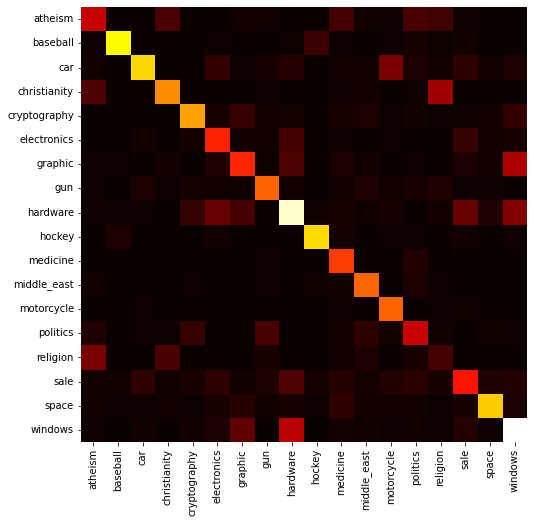

In [259]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_df, cmap='hot', cbar=False)

In [260]:
%%time
predictions2 = generate_predictions_pro(data_20ng)
prediction_labels2 = [labels[p] for p in predictions2]
true_labels = [mapping[l] for l in ds_20ng.label.tolist()]

print(classification_report(prediction_labels2, true_labels, digits=3))

              precision    recall  f1-score   support

     atheism      0.044     0.075     0.055       281
    baseball      0.181     0.329     0.234       328
         car      0.529     0.525     0.527       598
christianity      0.653     0.439     0.525       890
cryptography      0.069     0.237     0.107       173
 electronics      0.081     0.425     0.136       113
     graphic      0.046     0.165     0.072       164
         gun      0.291     0.723     0.415       220
    hardware      0.014     0.205     0.026        78
      hockey      0.790     0.418     0.547      1134
    medicine      0.108     0.790     0.190        81
 middle_east      0.030     0.210     0.053        81
  motorcycle      0.390     0.532     0.450       438
    politics      0.138     0.189     0.159       338
    religion      0.008     0.058     0.014        52
        sale      0.168     0.224     0.192       437
       space      0.664     0.216     0.326      1826
     windows      0.797    

<AxesSubplot:>

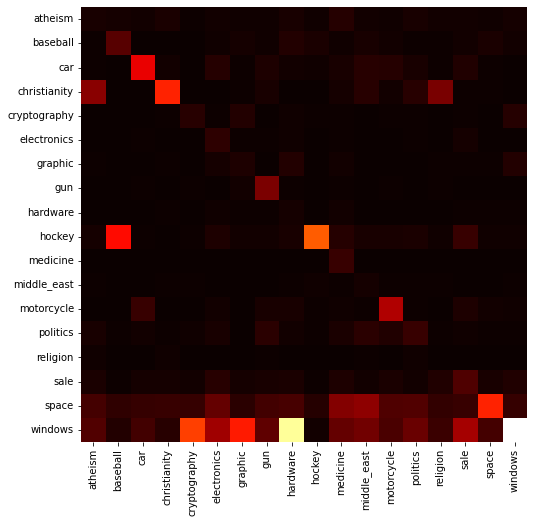

In [261]:
cm2 = confusion_matrix(prediction_labels2, true_labels)
cm2_df = pd.DataFrame(cm2, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm2_df, cmap='hot', cbar=False)